The objective of this notebook is no create a ML model capable pf predicting EMISIONES_EURO in order to fill the _null_ values in the dataset

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint
import polars as pl
import numpy as np
import pickle
import random
import os

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from utils.dictionaries import types_parque_post

# Test of a rf with a numerical variable

In [9]:
from utils.dictionaries import types_parque_post

path = os.path.join("..","Data", "DGT")
clean_park = os.path.join(path,'Parque_exacto','clean_park.csv')

cols = ["FECHA_MATR", "FECHA_PRIM_MATR", "CLASE_MATR", "MARCA", "MODELO",
    "TIPO", "TIPO_DGT", "PROPULSION", "CILINDRADA", "POTENCIA", "KW", "TARA","PESO_MAX", "MOM", 
    "MMTA", "PLAZAS", "PLAZAS_MAX", "NUEVO_USADO", "EMISIONES_CO2", "RENTING", "VARIANTE", 
    "VERSION", "FABRICANTE", "EMISIONES_EURO","CONSUMO", "ALIMENTACION", "CATELECT"]

parke = pl.scan_csv(clean_park,separator='|', schema=types_parque_post).select(cols).head(1000000)
parke = parke.filter(pl.col('EMISIONES_CO2').is_not_null(),
             pl.col('EMISIONES_EURO').is_not_null()).head(100000)
parke = parke.collect()

In [25]:
X = parke.select('EMISIONES_CO2').to_numpy()
y = parke.select('EMISIONES_EURO').to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [26]:
rf = RandomForestClassifier(n_estimators=100,max_depth=20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/Users/danibedmarromero/Documents/Academia/TFM_BSC/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.31842424242424244


# Test of a rf with a categorical variable

In [6]:
from utils.dictionaries import types_parque_post

path = os.path.join("..","Data", "DGT")
clean_park = os.path.join(path,'Parque_exacto','clean_park.csv')

parke = pl.scan_csv(clean_park,separator='|', schema=types_parque_post).select(['MARCA','EMISIONES_EURO']).head(1000000)
parke = parke.filter(pl.col('MARCA').is_not_null(),
             pl.col('EMISIONES_EURO').is_not_null()).head(100000)
parke = parke.collect()

In [7]:
X = parke.select('MARCA').to_dummies(drop_first=True).to_numpy()
y = parke.select('EMISIONES_EURO').to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [11]:
rf = RandomForestClassifier(n_estimators=100,max_depth=20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/Users/danibedmarromero/Documents/Academia/TFM_BSC/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.24881818181818183


# Test of a rf with a numerical and a categorical variable

In [2]:
from utils.dictionaries import types_parque_post

path = os.path.join("..","Data", "DGT")
clean_park = os.path.join(path,'Parque_exacto','clean_park.csv')

parke = pl.scan_csv(clean_park,separator='|', schema=types_parque_post).select(['MARCA','EMISIONES_CO2','EMISIONES_EURO']).head(1000000)
parke = parke.filter(pl.col('MARCA').is_not_null(),
             pl.col('EMISIONES_EURO').is_not_null(),
             pl.col('EMISIONES_CO2').is_not_null()).head(100000)
parke = parke.collect()

In [3]:
X = parke.select(['MARCA','EMISIONES_CO2']).to_dummies('MARCA',drop_first=True).to_numpy()
y = parke.select('EMISIONES_EURO').to_numpy().ravel()
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [49]:
rf = RandomForestClassifier(n_estimators=100,max_depth=20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4876969696969697


# Building of a workflow for posterioir scaling of the model

We need:
- A file from which we read the data (_clean_park for us_)
- List of the columns we will use *features and target included* (_columns for us_)
- List of the feature columns (_features_ for us)
- Name of the target variable (_'EMISIONES_EURO'_ for us)
- List of the features columns that are categorical (_categorical_features_ for us)

In [9]:
from utils.dictionaries import types_parque_post
path = os.path.join("..","Data", "DGT")
clean_park = os.path.join(path,'Parque_exacto','clean_park.csv')

# Read the file keepink just the usefull columns
columns = ["FECHA_MATR", "FECHA_PRIM_MATR", "CLASE_MATR", "TIPO_DGT", "PROPULSION", "CILINDRADA", 
           "POTENCIA", "KW", "TARA","PESO_MAX", "MOM", "MMTA", "PLAZAS", "PLAZAS_MAX", "NUEVO_USADO", 
           "EMISIONES_CO2", "RENTING", "EMISIONES_EURO","CONSUMO", "ALIMENTACION", "CATELECT",'MARCA',
           "MODELO","TIPO","VARIANTE","VERSION","FABRICANTE"]
parke = pl.scan_csv(clean_park,separator='|', schema=types_parque_post).select(columns).head(10000000)
parke = parke.drop_nulls().head(1000000)
parke = parke.collect()

#Merge the columns that indicate the car model and drop them
model_variables = ['MARCA',"MODELO","TIPO","VARIANTE","VERSION","FABRICANTE"]
parke = parke.with_columns((pl.col('MARCA') + " " + pl.col("MODELO") + " " + 
                            pl.col("TIPO") + " " + pl.col("FABRICANTE")).alias("MODEL")).drop(model_variables)

#Select which are categorical variables from the columns list
target = 'EMISIONES_EURO'
[columns.remove(i) for i in model_variables]
features = [col for col in columns if col != target]
features.append('MODEL')
categorical_features = []
for key in types_parque_post:
    if key in columns:
        if (types_parque_post[key] == pl.String) & (key!=target):
            categorical_features.append(key)
categorical_features.append('MODEL')

#Change datetimes columns to antiquity
import datetime 
reference_date = datetime.date(2023, 12, 29)

parke = parke.with_columns(((pl.lit(reference_date) - pl.col("FECHA_MATR"))
     .cast(pl.Duration).dt.total_days().cast(pl.Int32).alias("FECHA_MATR")),
     ((pl.lit(reference_date) - pl.col("FECHA_PRIM_MATR"))
     .cast(pl.Duration).dt.total_days().cast(pl.Int32).alias("FECHA_PRIM_MATR")))

X = parke.select(features).to_dummies(categorical_features,drop_first=True).to_numpy()
y = parke.select(target).to_numpy().ravel()
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [11]:
np.shape(X_test)

(102789, 1596)

# RandomSearchCV

Hyperparameters of the model:
- n_estimators: number of trees
  - n_estimators = randint(50,500)
- max_depth: maximum depth of each tree
  - max_depth = randint(5,40)
- max_features: number of features to consider when looking for the best split
  - max_features = ["log2","sqrt",None]
- min_samples_split: The minimum number of samples required to split an internal node
  - min_samples_split = [2, 5, 10]
- min_samples_leaf: The minimum number of samples required to be at a leaf node
  - min_samples_leaf = [1, 2, 4]

In [ ]:
random_grid = {'n_estimators': randint(50,500),
               'max_features': ['log2', 'sqrt', None],
               'max_depth': randint(5,40),
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf,param_distributions = random_grid,n_iter=5, cv=5, n_jobs=-1)
rand_search.fit(X_train, y_train)
random_search_model = rand_search.best_estimator_

model_file = os.path.join("..","Models","rf_model.pkl")
with open(model_file,'wb') as f:
    pickle.dump(random_search_model,f)

print('Best hyperparameters:',  rand_search.best_params_)
y_pred = random_search_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/Users/danibedmarromero/Documents/Academia/TFM_BSC/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x104733820>,
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12d9b21c0>})

'max_depth': 26, 'max_features': None, 'n_estimators': 117
'max_depth': 33, 'max_features': 'sqrt','n_estimators': 451, 'min_samples_leaf': 1, 'min_samples_split': 2, 

In [14]:
import time
start = time.time()
rf = RandomForestClassifier(n_estimators=117,
                            max_depth=26,
                            max_features=None,
                            n_jobs=-1,)
start = time.time()
rf.fit(X_train, y_train)
fit = time.time() - start
start = time.time()
y_pred = rf.predict(X_test)
pred = time.time() - start
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy premodel:", accuracy, "fit time:", fit, "pred time:", pred)

rf = RandomForestClassifier(n_estimators=451,
                            max_depth=33,
                            max_features='sqrt',
                            n_jobs=-1,)
start = time.time()
rf.fit(X_train, y_train)
fit = time.time() - start
start = time.time()
y_pred = rf.predict(X_test)
pred = time.time() - start
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy premodel:", accuracy, "fit time:", fit, "pred time:", pred)

Accuracy premodel: 0.5176666666666667 fit time: 162.038104057312 pred time: 1.4816601276397705
Accuracy premodel: 0.5189393939393939 fit time: 130.41594076156616 pred time: 5.27468729019165


In [5]:
rf_file = os.path.join("..","Models","rf_model2.pkl")
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Best hyperparameters:", best_rf.get_params())
with open(rf_file,'wb') as f:
    pickle.dump(best_rf,f)


Accuracy: 0.5202424242424243
Best hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 57, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 82, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [106]:
best_rf = rand_search.best_estimator_

print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 26, 'max_features': None, 'n_estimators': 117}


# GridSearchCV

In [ ]:
path = os.path.join("..","Data", "DGT")
complete_park = os.path.join(path,'Parque_exacto','clean_park.csv')
model_file = os.path.join("..","Models","rf_model2.pkl")

loaded_model = pickle.load(open(model_file, 'rb'))
params = loaded_model.get_params()

param_grid = {
    'n_estimators': list(range(params['n_estimators'] - 25, params['n_estimators'] + 25, 5)),
    'max_depth': list(range(params['max_depth'] - 5, params['max_depth'] + 5, 1)),
    'max_features': params['max_features'],
    'min_samples_split': params['min_samples_split'],
    'min_samples_leaf': params['min_samples_leaf'] 
}

2

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint
import polars as pl
import numpy as np
import pickle
import random
import os

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from utils.dictionaries import types_parque_post

path = os.path.join("..","Data", "DGT")
clean_park = os.path.join(path,'Parque_exacto','clean_park.csv')

# Read the file keepink just the usefull columns
columns = ["FECHA_PRIM_MATR", "CLASE_MATR", "TIPO_DGT", "PROPULSION", "CILINDRADA", 
           "POTENCIA", "KW","EMISIONES_CO2", "EMISIONES_EURO","CONSUMO", "ALIMENTACION", 
           "CATELECT",'MARCA',"MODELO","TIPO","VARIANTE","VERSION","FABRICANTE"]
parke = pl.scan_csv(clean_park,separator='|', schema=types_parque_post).select(columns)
#parke = parke.drop_nulls()
parke = parke.collect()

#Merge the columns that indicate the car model and drop them
model_variables = ['MARCA',"MODELO","TIPO","VARIANTE","VERSION","FABRICANTE"]
parke = parke.with_columns((pl.col('MARCA') + " " + pl.col("MODELO") + " " + 
                            pl.col("TIPO") + " " + pl.col("FABRICANTE")).alias("MODEL")).drop(model_variables)

#Change datetimes columns to antiquity
import datetime 
reference_date = datetime.date(2023, 12, 29)

parke = parke.with_columns((
    pl.lit(reference_date) - pl.col("FECHA_PRIM_MATR"))
    .cast(pl.Duration).dt.total_days().cast(pl.Int32).alias("AGE_OF_THE_CAR"))

#Simplify EURO_EMISIONS according to their registartion date
parke = parke.with_columns([
    pl.when(pl.col("FECHA_PRIM_MATR") >= pl.lit(datetime.date(2015, 9, 1))).then(pl.lit("EURO_6"))
    .when(pl.col("FECHA_PRIM_MATR") >= pl.lit(datetime.date(2011, 1, 1))).then(pl.lit("EURO_5"))
    .when(pl.col("FECHA_PRIM_MATR") >= pl.lit(datetime.date(2006, 1, 1))).then(pl.lit("EURO_4"))
    .when(pl.col("FECHA_PRIM_MATR") >= pl.lit(datetime.date(2001, 1, 1))).then(pl.lit("EURO_3"))
    .when(pl.col("FECHA_PRIM_MATR") >= pl.lit(datetime.date(1997, 1, 1))).then(pl.lit("EURO_2"))
    .when(pl.col("FECHA_PRIM_MATR") >= pl.lit(datetime.date(1992, 12, 31))).then(pl.lit("EURO_1"))
    .when(pl.col("FECHA_PRIM_MATR") < pl.lit(datetime.date(1992, 12, 31))).then(pl.lit("Previous"))
    .otherwise(pl.lit("Unkwown"))
    .alias("Simplified_EURO")
])

#Add the elctric and hidrogen cars to a new clean category
parke = parke.with_columns(
    pl.when((pl.col("PROPULSION") == "ELEC") | (pl.col("PROPULSION") == "H"))
      .then(pl.lit("EURO_CLEAN"))
      .otherwise(pl.col("Simplified_EURO"))
      .alias("Simplified_EURO")
)

In [3]:
path = os.path.join("..","Data", "DGT")
clean_park = os.path.join(path,'Parque_exacto','clean_park.csv')

park = pl.scan_csv(clean_park,separator='|', schema=types_parque_post)
park = park.collect()
park = park.null_count()
["PROVINCIA","MARCA","MODELO","FECHA_MATR","FECHA_PRIM_MATR","CLASE_MATR",
"TIPO_TITULAR","NUM_TITULARES","TIPO_DGT","TARA","PESO_MAX","CILINDRADA",
"POTENCIA","TIPO_DISTINTIVO","PLAZAS","PLAZAS_MAX"]
# Step 2: melt it (turn it into two columns: "column" and "null_count")
null_counts_melted = park.melt(variable_name="column", value_name="null_count")

# Step 3: filter columns with null_count == 0
columns_without_nulls = null_counts_melted.filter(
    pl.col("null_count") == 0
)["column"].to_list()

print(columns_without_nulls)

['PROVINCIA', 'MARCA', 'MODELO', 'FECHA_MATR', 'FECHA_PRIM_MATR', 'CLASE_MATR', 'NUEVO_USADO', 'TIPO_TITULAR', 'NUM_TITULARES', 'TIPO_DGT', 'TARA', 'PESO_MAX', 'CILINDRADA', 'POTENCIA', 'TIPO_DISTINTIVO', 'PLAZAS', 'PLAZAS_MAX']


/var/folders/gk/9s2n71rj4fq128zrj3x599pr0000gn/T/ipykernel_3443/185689199.py:11: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  null_counts_melted = park.melt(variable_name="column", value_name="null_count")


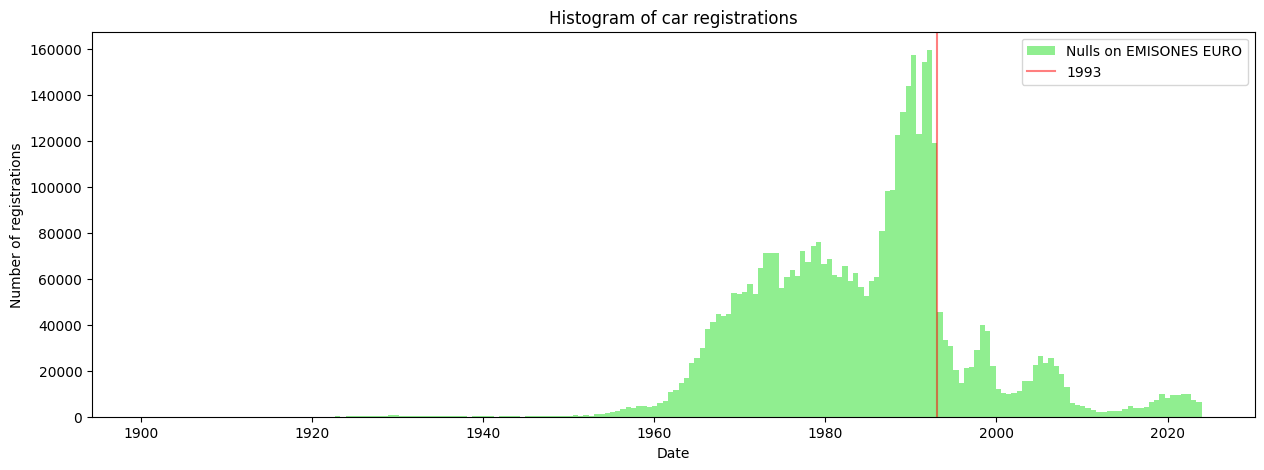

In [4]:
import matplotlib.pyplot as plt
import datetime

faltan = parke.filter(pl.col('EMISIONES_EURO').is_null()).select('FECHA_PRIM_MATR').get_columns()[0]
faltan_list = faltan.to_list()

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.hist(faltan_list, 
        bins=200,
        log=False,
        alpha=1,
        color='lightgreen',
        label='Nulls on EMISONES EURO')

ax.axvline(x=datetime.date(1993, 1, 1), color='red', label='1993', alpha=0.5)

ax.set_title('Histogram of car registrations')
ax.set_xlabel('Date')
ax.set_ylabel('Number of registrations')
ax.legend()

plt.show()

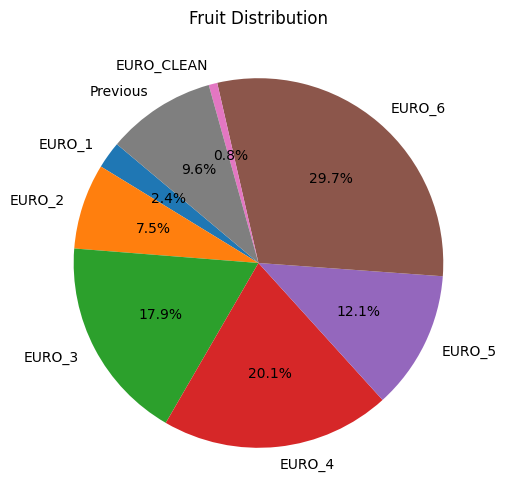

In [8]:
df = parke['Simplified_EURO'].value_counts().sort('Simplified_EURO')
# Extract categories and values
categories = df["Simplified_EURO"].to_list()
values = df["count"].to_list()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Fruit Distribution')
plt.show()